# Shorthand to text transformer architecture

## Setup and Imports

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

## Compile smaller data selection (random)

In [34]:
# import os
# import shutil
# import random
# from pathlib import Path

# def create_mini_dataset(source_dir='data', target_dir='data-Mini', percentage=0.01):
#     # Create target directory if it doesn't exist
#     Path(target_dir).mkdir(parents=True, exist_ok=True)
    
#     # Get all image files
#     image_files = [f for f in os.listdir(source_dir) 
#                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
#     # Calculate number of files to select
#     num_files = len(image_files)
#     num_files_to_select = max(1, int(num_files * percentage))
    
#     # Randomly select files
#     selected_files = random.sample(image_files, num_files_to_select)
    
#     # Copy selected files to new directory
#     for file_name in selected_files:
#         source_path = os.path.join(source_dir, file_name)
#         target_path = os.path.join(target_dir, file_name)
#         shutil.copy2(source_path, target_path)
    
#     print(f"Original dataset size: {num_files} images")
#     print(f"Mini dataset size: {num_files_to_select} images")
#     print(f"Mini dataset created in: {target_dir}")

# # Create the mini dataset
# # Example with different parameters
# create_mini_dataset(
#     source_dir='data',
#     target_dir='data_mini',
#     percentage=0.01  # 5% instead of 1%
# )

## Data Loading

In [35]:
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

class KeepAspectRatioPad(object):
    """
    Resize the image to fit within the target size while preserving aspect ratio,
    then pad the result to the target size.
    """
    def __init__(self, target_size=(64, 64), fill=255):
        self.target_size = target_size
        self.fill = fill  # Color to use for padding
        
    def __call__(self, img):
        # Get original dimensions
        w_orig, h_orig = img.size
        w_target, h_target = self.target_size
        
        # Determine scale factor to maintain aspect ratio
        aspect_ratio = w_orig / h_orig
        
        if aspect_ratio > 1:
            # Image is wider than tall
            new_w = min(w_orig, w_target)
            new_h = int(new_w / aspect_ratio)
        else:
            # Image is taller than wide (or square)
            new_h = min(h_orig, h_target)
            new_w = int(new_h * aspect_ratio)
            
        # Resize maintaining aspect ratio
        resized_img = img.resize((new_w, new_h), Image.LANCZOS)
        
        # Create new image with target size and paste resized image
        new_img = Image.new(img.mode, self.target_size, self.fill)
        
        # Calculate position for pasting (center)
        paste_x = (w_target - new_w) // 2
        paste_y = (h_target - new_h) // 2
        
        # Paste resized image onto padded background
        new_img.paste(resized_img, (paste_x, paste_y))
        
        return new_img
    
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to single channel if not already
    KeepAspectRatioPad(target_size=(64, 64), fill=0),  # Preserve aspect ratio and pad
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # For grayscale
])


In [46]:
import os
import pickle

def load_phonetic_dict(pickle_file='phonetic_cache.pkl', text_file='phonetics_output.txt'):
    """Load phonetic dictionary from either pickle or text file"""
    # Try loading from pickle first (faster)
    if os.path.exists(pickle_file):
        try:
            with open(pickle_file, 'rb') as f:
                phonetic_dict = pickle.load(f)
            print(f"Loaded {len(phonetic_dict)} words from phonetic cache")
            return phonetic_dict
        except Exception as e:
            print(f"Error loading pickle file: {e}")
    
    # Fall back to text file
    if os.path.exists(text_file):
        try:
            phonetic_dict = {}
            with open(text_file, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                
            # Skip header lines
            for line in lines[2:]:  # Skip "WORD PHONETICS" and the dashes
                if '\t' in line:
                    word, phonetics = line.strip().split('\t')
                    phonetic_dict[word] = list(phonetics)
            
            print(f"Loaded {len(phonetic_dict)} words from text file")
            return phonetic_dict
        except Exception as e:
            print(f"Error loading text file: {e}")
    
    print("No phonetic dictionary found, returning empty dictionary")
    return {}

# Load the phonetic dictionary
phonetic_dict = load_phonetic_dict()

No phonetic dictionary found, returning empty dictionary


In [51]:
class ShorthandDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            KeepAspectRatioPad(target_size=(64, 64), fill=255),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
        self.image_files = [f for f in os.listdir(data_dir) 
                           if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.labels = [os.path.splitext(f)[0] for f in self.image_files]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.labels[idx]

In [53]:
# Define transforms
transform = transforms.Compose([
            transforms.Grayscale(),
            KeepAspectRatioPad(target_size=(64, 64), fill=255),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])

# Now create the dataset
dataset = ShorthandDataset('data', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

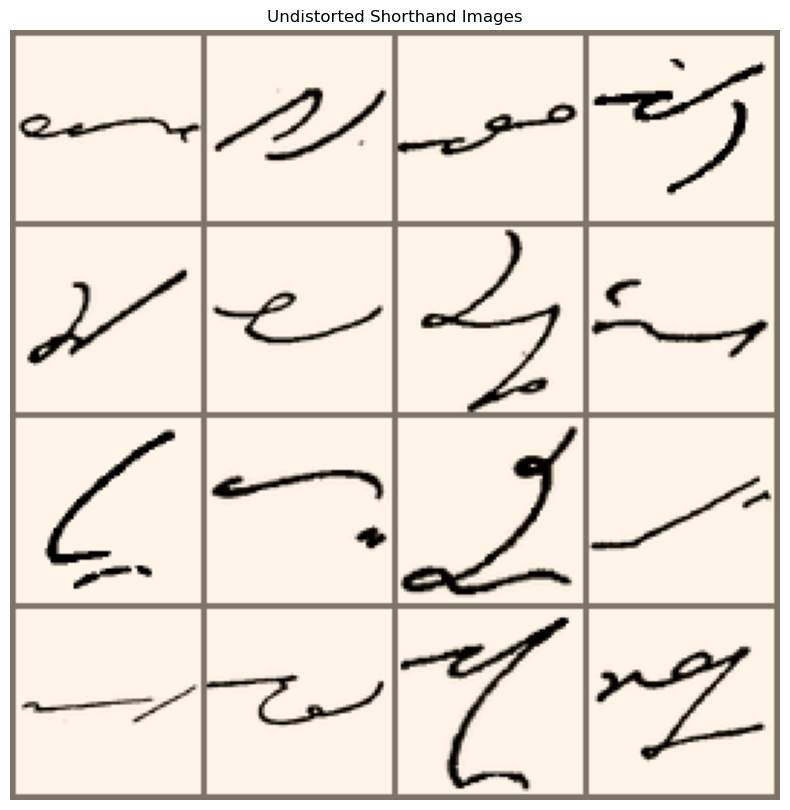

Batch shape: torch.Size([32, 1, 64, 64])
Sample labels: ('arrogance', 'deformity', 'northerner', 'notification', 'feud')


In [54]:
# Create a function to visualize the results
def visualize_undistorted_batch(dataloader):
    """
    Visualize a batch of images to verify they're not stretched
    """
    images, labels = next(iter(dataloader))
    
    # Create a grid of images
    grid = torchvision.utils.make_grid(images[:16], nrow=4)
    
    # Unnormalize
    if grid.shape[0] == 1:  # Grayscale
        mean = torch.tensor([0.485]).view(1, 1, 1)
        std = torch.tensor([0.229]).view(1, 1, 1)
    else:  # RGB
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    grid = grid * std + mean
    grid = torch.clamp(grid, 0, 1)
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Undistorted Shorthand Images")
    plt.show()
    
    print(f"Batch shape: {images.shape}")
    print(f"Sample labels: {labels[:5]}")
visualize_undistorted_batch(dataloader)

## Attention Layer

In [55]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: [batch, seq_len, hidden]
        attention_scores = self.attention(x)  # [batch, seq_len, 1]
        attention_weights = F.softmax(attention_scores, dim=1)
        context = torch.sum(x * attention_weights, dim=1)  # [batch, hidden]
        return context, attention_weights

## Main Model

In [56]:
class ShorthandModel(nn.Module):
    def __init__(self, num_phonetic_units, phonetic_units, dropout_rate=0.3):
        super(ShorthandModel, self).__init__()
        self.phonetic_units = phonetic_units
        self.blank_idx = num_phonetic_units
        self.lstm_hidden_size = 512


        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(dropout_rate)

        
        # Check size after convolutions
        self.calc_conv_output_size()

        # Dense layer to prepare for LSTM
        self.fc_prep = nn.Linear(self.conv_output_size, 512)
        self.dropout_fc = nn.Dropout(dropout_rate)


        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=512,          # Size of each time step input
            hidden_size=512,         # Size of LSTM hidden state
            num_layers=3,            # Number of LSTM layers
            bidirectional=True,      # Use bidirectional LSTM
            batch_first=True,         # Batch dimension first
            dropout=dropout_rate if dropout_rate > 0 else 0

        )
        
        self.attention = AttentionLayer(self.lstm_hidden_size * 2)  # *2 for bidirectional

        # Output layer - num_phonetic_units + 1 for blank token (CTC requirement)
        self.output = nn.Linear(self.lstm_hidden_size * 2, num_phonetic_units + 1)  # *2 for bidirectional

        # Add training-specific attributes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = nn.CTCLoss(blank=num_phonetic_units)  # blank token added

        self._initialize_weights()

        # Add dictionary to map indices to phonetic units
        self.idx_to_phonetic = {i: unit for i, unit in enumerate(phonetic_units)}
        self.idx_to_phonetic[num_phonetic_units] = '<blank>'  # Add blank token

    def calc_conv_output_size(self):
        # Helper function to calculate conv output size
        # 1=Batch size, 1:Num of color channels, (64,64):Image size
        x = torch.randn(1, 1, 64, 64)
        # Apply convolutions with pooling
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        # Get dimensions after convolutions
        self.conv_output_shape = x.shape
        _, C, H, W = x.shape
        # Total flattened size
        self.conv_output_size = C * H * W
        # Print sizes for debugging
        print(f"Conv output shape: {x.shape}")
        print(f"Conv output size: {self.conv_output_size}")

        
    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with regularization
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)
        
        # Apply the same dynamic FC layer but with safety checks
        _, C, H, W = x.size()
        
        # For debugging
        if W == 0 or H == 0:
            print(f"Error: Invalid dimensions: C={C}, H={H}, W={W}")
            return torch.zeros(batch_size, 1, len(self.phonetic_units) + 1, device=self.device)
        
        x = x.permute(0, 3, 1, 2)  # [batch, width, channels, height]
        batch_size, seq_len, channels, height = x.size()
        
        # Reshape with safety check
        try:
            x = x.reshape(batch_size * seq_len, channels * height)
        except RuntimeError as e:
            print(f"Reshape error: {e}")
            print(f"Sizes: batch={batch_size}, seq={seq_len}, C={channels}, H={height}")
            # Return zeros as fallback to avoid crash
            return torch.zeros(batch_size, seq_len, len(self.phonetic_units) + 1, device=self.device)
        
        # Dynamically recreate fc_prep if needed
        required_input_size = channels * height
        if not hasattr(self, 'actual_input_size') or self.actual_input_size != required_input_size:
            self.actual_input_size = required_input_size
            self.fc_prep = nn.Linear(required_input_size, 512).to(self.device)
            print(f"Recreated fc_prep layer with input size: {required_input_size}")
        
        # Apply FC with NaN check
        x = self.fc_prep(x)
        x = F.relu(x)
        if torch.isnan(x).any():
            print("Warning: NaN values after FC layer")
            x = torch.nan_to_num(x, nan=0.0)
        
        x = self.dropout_fc(x)
        x = x.view(batch_size, seq_len, 512)
        
        # LSTM with safety
        try:
            lstm_out, _ = self.lstm(x)
        except RuntimeError as e:
            print(f"LSTM error: {e}")
            return torch.zeros(batch_size, seq_len, len(self.phonetic_units) + 1, device=self.device)
        
        # Apply attention to get global context
        context, attention_weights = self.attention(lstm_out)
        
        # Apply output layer directly to LSTM output
        # Using attention as a separate feature extractor rather than modifying sequence
        output = self.output(lstm_out)
        
        # Return log_probs directly to avoid NaN later
        return F.log_softmax(output, dim=2)
    
    # def decode_greedy(self, output, lengths=None):
    #     # Get the highest probability unit for each sample
    #     max_probs, max_indices = torch.max(output, dim=1)  # dim=1 for phonetic units dimension
    #     batch_size = max_indices.size(0)
        
    #     results = []
    #     for b in range(batch_size):
    #         idx = max_indices[b].item()
    #         # Convert index to phonetic unit if valid
    #         if idx < len(self.phonetic_units):
    #             results.append(self.phonetic_units[idx])
    #         else:
    #             results.append('')  # Empty string for invalid index
        
    #     return results

    # Improved CTC decoder that properly handles blank tokens
    def decode_ctc(self, log_probs):
        """
        Properly decodes CTC output log probabilities into phonetic sequences
        """
        batch_size, seq_len, num_classes = log_probs.shape
        
        # Convert to probabilities
        probs = torch.exp(log_probs)
        
        # Get the most likely class at each timestep
        max_probs, max_indices = torch.max(probs, dim=2)  # [batch_size, seq_len]
        
        # Process each batch
        results = []
        for b in range(batch_size):
            # Extract indices and their probabilities
            indices = max_indices[b].cpu().numpy()
            prob_values = max_probs[b].cpu().numpy()
            
            # For debugging - show all tokens for a few examples
            if b == 0:
                print("\nRaw prediction sequence (first 10 tokens):")
                for i in range(min(10, seq_len)):
                    token_idx = indices[i]
                    token = self.phonetic_units[token_idx] if token_idx < len(self.phonetic_units) else '<blank>'
                    print(f"Token {i}: {token} (prob: {prob_values[i]:.4f})")
            
            # Perform CTC collapsing: remove duplicates and blanks
            collapsed = []
            for i, idx in enumerate(indices):
                # Skip blank tokens
                if idx == self.blank_idx:
                    continue
                    
                # Add token if it's not a duplicate of the previous non-blank token
                if len(collapsed) == 0 or idx != collapsed[-1]:
                    collapsed.append(idx)
            
            # Convert indices to phonetic units
            # If we end up with an empty sequence, add the second most likely non-blank token
            if len(collapsed) == 0:
                # Find the most likely non-blank token
                avg_probs = probs[b].mean(dim=0).cpu().numpy()
                # Create a copy and set blank token probability to 0
                non_blank_probs = avg_probs.copy()
                non_blank_probs[self.blank_idx] = 0
                # Get the most likely non-blank token
                best_token = np.argmax(non_blank_probs)
                phonetic_seq = [self.phonetic_units[best_token]] if best_token < len(self.phonetic_units) else ['?']
            else:
                phonetic_seq = [self.phonetic_units[idx] if idx < len(self.phonetic_units) else '?' 
                            for idx in collapsed]
            
            results.append(''.join(phonetic_seq))
        
        return results
    
    def _initialize_weights(self):
        """Initialize model weights to prevent exploding gradients"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)
    
    def phonetics_to_tensor(self, phonetic_sequences):
        """Convert phonetic sequences to tensor of indices"""
        # Create mapping of phonetic unit to index
        unit_to_idx = {unit: idx for idx, unit in enumerate(self.phonetic_units)}
        
        # Convert sequences to index tensors
        tensors = []
        for seq in phonetic_sequences:
            indices = [unit_to_idx.get(unit, 0) for unit in seq]  # Default to 0 if not found
            tensors.append(torch.tensor(indices, dtype=torch.long))
        
        # Get sequence lengths for CTC
        seq_lengths = [len(t) for t in tensors]
        
        # Pad sequences to same length
        max_len = max(seq_lengths)
        padded = torch.full((len(tensors), max_len), len(self.phonetic_units), dtype=torch.long)  # pad with blank token
        for i, t in enumerate(tensors):
            padded[i, :len(t)] = t
            
        return padded.to(self.device), torch.tensor(seq_lengths, dtype=torch.long).to(self.device)

#     def train_batch(self, images, phonetic_sequences, batch_num):
#         """Train on a batch of images"""
#         self.train()
#         self.optimizer.zero_grad()
        
#         # Prepare data
#         images = images.to(self.device)  # [batch_size, 1, 64, 64]
#         targets = self.phonetics_to_tensor(phonetic_sequences)
        
#         # Forward pass
#         log_probs = F.log_softmax(self(images), dim=-1)
        
#         # Calculate loss
#         batch_size = images.size(0)
#         input_lengths = torch.full((batch_size,), log_probs.size(1), dtype=torch.long)
#         target_lengths = torch.tensor([len(t) for t in phonetic_sequences], dtype=torch.long)
        
#         loss = self.criterion(log_probs, targets, input_lengths, target_lengths)
        
#         # Backward pass and optimize
#         loss.backward()
#         self.optimizer.step()
        
#         self.batchesTrained += 1
#         return loss.item()

#     def infer_batch(self, images):
#         """Recognize phonetic sequences in batch of images"""
#         self.eval()
#         with torch.no_grad():
#             # Prepare data
#             images = images.to(self.device)
            
#             # Forward pass
#             output = self(images)
#             log_probs = F.log_softmax(output, dim=-1)
            
#             # Decode
#             decoded_sequences = self.decode_greedy(log_probs)
            
#         return decoded_sequences


# # def decodeGreggShorthand(self, probabilities, input_lengths):
# #     """Specialized decoder for Gregg shorthand"""
# #     # First pass: Get most likely phonetic units
# #     phonetic_transcription = self.decodeGreedy(probabilities, input_lengths)
    
# #     # Second pass: Apply phonetic-to-text rules
# #     text_results = []
# #     for transcript in phonetic_transcription:
# #         # Apply contextual rules to convert phonetic to text
# #         # Handle brief forms (common words with special symbols)
# #         # Resolve ambiguities using language model
# #         text = self.phoneticToText(transcript)
# #         text_results.append(text)
    
# #     return text_results

## Translate words to phonetics

In [59]:
import pickle
import os
import requests
import time
from tqdm.notebook import tqdm  # For Jupyter notebook progress bars
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

def extract_words_from_dataset(dataset):
    """Extract unique words from dataset"""
    unique_words = set()
    for _, labels in tqdm(dataset, desc="Extracting words"):
        if isinstance(labels, str):
            unique_words.add(labels)
        elif isinstance(labels, list) or isinstance(labels, tuple):
            unique_words.update(labels)
    
    return list(unique_words)

def get_phonetics_in_batches(words, batch_size=50):
    """Process words in batches and get phonetic translations"""
    API_URL = "https://api.anthropic.com/v1/messages"
    API_KEY = os.getenv("ANTHROPIC_API_KEY")
    
    if not API_KEY:
        print("Warning: No API key found. Using fallback.")
        return {word: list(word.lower()) for word in words}
    
    # Full results dictionary
    phonetic_dict = {}
    
    # Calculate number of batches
    num_batches = (len(words) + batch_size - 1) // batch_size
    
    # Process each batch
    for i in tqdm(range(num_batches), desc="Processing batches"):
        # Get current batch
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(words))
        batch = words[start_idx:end_idx]
        
        # Create prompt
        prompt = f"""Convert these English words to IPA (International Phonetic Alphabet).
Return only the word and its IPA pronunciation, separated by a tab, one per line. DO NOT INCLUDE slashes / or stress marks ˈ:

{' '.join(batch)}"""
        
        # Call API
        headers = {
            "Content-Type": "application/json",
            "x-api-key": API_KEY,
            "anthropic-version": "2023-06-01"
        }
        
        data = {
            "model": "claude-3-7-sonnet-20250219",
            "max_tokens": 50000,
            "messages": [{"role": "user", "content": prompt}]
        }
        
        try:
            response = requests.post(API_URL, headers=headers, json=data)
            response.raise_for_status()
            result = response.json()
            text = result["content"][0]["text"]
            
            # Parse response
            batch_dict = {}
            for line in text.strip().split('\n'):
                if '\t' in line:
                    word, ipa = line.split('\t')
                    word = word.strip()
                    batch_dict[word] = list(ipa.strip())
            
            # Update main dictionary
            phonetic_dict.update(batch_dict)
            
            # Save progress after each batch
            with open('phonetics_output.txt', 'w') as f:
                f.write("WORD\tPHONETICS\n")
                f.write("-" * 40 + "\n")
                for word, phonetics in phonetic_dict.items():
                    f.write(f"{word}\t{''.join(phonetics)}\n")
            
            # Also save to pickle
            with open('phonetic_cache.pkl', 'wb') as f:
                pickle.dump(phonetic_dict, f)
            
            print(f"Batch {i+1}/{num_batches} complete. Processed {len(phonetic_dict)}/{len(words)} words.")
            
            # Add a small delay between batches
            if i < num_batches - 1:
                time.sleep(1)
                
        except Exception as e:
            print(f"Error processing batch {i+1}: {e}")
            # Continue with next batch
    
    return phonetic_dict

def update_dataset_with_phonetics(dataset, phonetic_dict):
    """Update ShorthandDataset to include phonetic translations"""
    class UpdatedShorthandDataset(Dataset):
        def __init__(self, original_dataset, phonetic_dict):
            self.dataset = original_dataset
            self.phonetic_dict = phonetic_dict
        
        def __len__(self):
            return len(self.dataset)
        
        def __getitem__(self, idx):
            image, word = self.dataset[idx]
            
            # Get phonetic representation
            phonetic = self.phonetic_dict.get(word, list(word.lower()))
            
            # Return image with word,phonetic pair
            return image, (word, phonetic)
    
    return UpdatedShorthandDataset(dataset, phonetic_dict)

# Main execution
def process_dataset(dataset):
    # 1. Extract unique words
    words = extract_words_from_dataset(dataset)
    print(f"Found {len(words)} unique words")
    
    # 2. Get phonetics in batches
    phonetic_dict = get_phonetics_in_batches(words)
    print(f"Completed phonetic translations for {len(phonetic_dict)} words")
    
    # 3. Create updated dataset
    updated_dataset = update_dataset_with_phonetics(dataset, phonetic_dict)
    
    return updated_dataset, phonetic_dict

In [61]:
# Process your dataset
updated_dataset, phonetic_dict = process_dataset(dataset)

# Now you can use the updated dataset with DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(updated_dataset, batch_size=32, shuffle=True)

# Check a sample from the updated dataset
image, (word, phonetic) = next(iter(updated_dataset))
print(f"Word: {word}")
print(f"Phonetic: {''.join(phonetic)}")

Extracting words:   0%|          | 0/15280 [00:00<?, ?it/s]

Found 15280 unique words


Processing batches:   0%|          | 0/306 [00:00<?, ?it/s]

Batch 1/306 complete. Processed 50/15280 words.
Batch 2/306 complete. Processed 100/15280 words.
Batch 3/306 complete. Processed 150/15280 words.
Batch 4/306 complete. Processed 200/15280 words.
Batch 5/306 complete. Processed 250/15280 words.
Batch 6/306 complete. Processed 300/15280 words.
Batch 7/306 complete. Processed 350/15280 words.
Batch 8/306 complete. Processed 400/15280 words.
Batch 9/306 complete. Processed 450/15280 words.
Batch 10/306 complete. Processed 500/15280 words.
Batch 11/306 complete. Processed 550/15280 words.
Batch 12/306 complete. Processed 600/15280 words.
Batch 13/306 complete. Processed 650/15280 words.
Batch 14/306 complete. Processed 700/15280 words.
Batch 15/306 complete. Processed 750/15280 words.
Batch 16/306 complete. Processed 800/15280 words.
Batch 17/306 complete. Processed 850/15280 words.
Batch 18/306 complete. Processed 900/15280 words.
Batch 19/306 complete. Processed 950/15280 words.
Batch 20/306 complete. Processed 1000/15280 words.
Batch 21/

## Train and Test

In [62]:
def train(model, train_loader, val_loader, num_epochs=10):
    # Use a much lower learning rate and L2 regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
    
    # Gradient clipping to prevent exploding gradients
    clip_value = 0.5
    
    # Count phonetic unit frequencies across the dataset
    phonetic_counts = Counter()
    num_phonetic_units = len(model.phonetic_units)
    
    # Load phonetic dictionary
    cache_file = 'phonetic_cache.pkl'
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            phonetic_dict = pickle.load(f)
        print(f"Loaded {len(phonetic_dict)} words from phonetic cache")
    else:
        phonetic_dict = {}
    
    # Store the phonetic dictionary in the model
    model.phonetic_dict = phonetic_dict
    
    # Count frequency of each phonetic unit in training set
    print("Calculating phonetic unit frequencies...")
    all_phonetic_units = []
    for _, labels in train_loader:
        for label in labels:
            if label in phonetic_dict:
                phonetic_seq = phonetic_dict.get(label, ['ə'])
                all_phonetic_units.extend(phonetic_seq)
    
    # Count occurrences
    phonetic_counts = Counter(all_phonetic_units)
    print(f"Phonetic unit counts: {dict(phonetic_counts.most_common(10))}")
    
    # Create weight tensor based on inverse frequency
    weights = torch.ones(num_phonetic_units + 1, device=model.device)

    # Set blank token weight
    blank_weight = 0.1  # Low weight to discourage blank predictions
    weights[model.blank_idx] = blank_weight

    # Set weights for phonetic units
    for idx, unit in enumerate(model.phonetic_units):
        if unit in phonetic_counts and phonetic_counts[unit] > 0:
            # Inverse frequency weighting with smoothing
            weights[idx] = 1.0 / (phonetic_counts[unit] + 1)
            
            # Special handling for common units
            if unit == 'ə':
                weights[idx] *= 15.0  # Even stronger penalty for schwa
            elif phonetic_counts[unit] > 200:
                weights[idx] *= 5.0
            
            # Also boost weights for rare units to encourage their prediction
            elif phonetic_counts[unit] < 50:
                weights[idx] *= 2.0

    # Normalize weights
    weights = weights / weights.mean() * 2.0

    # Print the weights for key tokens
    print(f"Weight for blank token: {weights[model.blank_idx]:.4f}")
    print(f"Weight for 'ə': {weights[model.phonetic_units.index('ə')]:.4f}")
    if 'æ' in model.phonetic_units:
        print(f"Weight for 'æ': {weights[model.phonetic_units.index('æ')]:.4f}")
    
    # Define an improved weighted CTC loss function
    class WeightedCTCLoss(nn.Module):
        def __init__(self, blank_idx, weights):
            super().__init__()
            self.blank_idx = blank_idx
            self.ctc_loss = nn.CTCLoss(blank=blank_idx, reduction='none', zero_infinity=True)
            self.weights = weights
            
        def forward(self, log_probs, targets, input_lengths, target_lengths):
            # Standard CTC loss calculation
            per_sample_loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)
            
            # Apply weights based on the target units
            # We'll create a simple scaling factor based on the average weight of the target units
            target_weights = torch.ones_like(per_sample_loss, device=model.device)
            
            # For each sample, calculate average weight of its target units
            for i in range(len(targets)):
                if target_lengths[i] > 0:
                    # Get the actual target indices for this sample
                    sample_targets = targets[i][:target_lengths[i]]
                    # Look up weights for each target index
                    sample_weights = torch.tensor([self.weights[idx] for idx in sample_targets], 
                                                device=model.device)
                    # Use average weight as the scaling factor for this sample's loss
                    target_weights[i] = sample_weights.mean()
            
            # Return weighted loss
            return (per_sample_loss * target_weights).mean()

    # Create the weighted loss with the calculated weights
    criterion = WeightedCTCLoss(model.blank_idx, weights)

    
    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        valid_batches = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to device
            images = images.to(model.device)
            
            # Convert words to phonetic sequences
            phonetic_sequences = []
            for label in labels:
                # Get phonetic sequence from dictionary or default to schwa
                phonetic_seq = phonetic_dict.get(label, ['ə'])
                # Ensure reasonable sequence length
                if len(phonetic_seq) > 20:
                    phonetic_seq = phonetic_seq[:20]
                phonetic_sequences.append(phonetic_seq)
            
            # Forward pass with added stability
            optimizer.zero_grad()
            
            try:
                # Get model outputs
                outputs = model(images)
                
                # Apply log softmax with numerical stability
                log_probs = F.log_softmax(outputs, dim=2).clamp(min=-100, max=100)
                
                # Check for NaN/Inf
                if torch.isnan(log_probs).any() or torch.isinf(log_probs).any():
                    print(f"Warning: NaN/Inf in log_probs (batch {batch_idx}), skipping")
                    continue
                
                # Prepare targets for CTC loss (with sequence length checks)
                targets, target_lengths = model.phonetics_to_tensor(phonetic_sequences)
                
                # Verify target lengths aren't too long compared to input
                seq_len = log_probs.size(1)
                for i in range(len(target_lengths)):
                    if target_lengths[i] > seq_len:
                        target_lengths[i] = seq_len
                
                # Input lengths are sequence length from model output
                input_lengths = torch.full((images.size(0),), seq_len, 
                                         dtype=torch.long).to(model.device)
                
                # Calculate weighted CTC loss with error handling
                try:
                    loss = criterion(log_probs.transpose(0, 1), targets, 
                                    input_lengths, target_lengths)
                    
                    # Check for NaN/Inf
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"Warning: NaN/Inf loss in batch {batch_idx}, skipping")
                        continue
                        
                    # Backward pass with gradient clipping
                    loss.backward()
                    
                    # Apply gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                    
                    # Check gradients for NaN/Inf
                    has_bad_grad = False
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                print(f"Warning: NaN/Inf gradient in {name}, skipping update")
                                has_bad_grad = True
                                break
                    
                    if not has_bad_grad:
                        optimizer.step()
                        total_loss += loss.item()
                        valid_batches += 1
                    
                except RuntimeError as e:
                    print(f"CTC Loss error: {e}")
                    continue
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
            
            # Print progress with improved formatting to show phonetic representations
            if batch_idx % 5 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Valid batches: {valid_batches}')
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        # Inside the validation phase, add this code:
        with torch.no_grad():
            for images, labels in val_loader:
                if len(images) > 0:
                    images = images.to(model.device)
                    
                    # Forward pass
                    outputs = model(images)
                    log_probs = F.log_softmax(outputs, dim=2)
                    
                    # Print distribution of probabilities for first example
                    probs = torch.exp(log_probs[0].mean(dim=0))  # Average over time steps
                    top_k = torch.topk(probs, min(10, len(model.phonetic_units)))
                    print("\nProbability distribution for first example:")
                    for i, idx in enumerate(top_k.indices):
                        unit = model.phonetic_units[idx] if idx < len(model.phonetic_units) else '<blank>'
                        print(f"{unit}: {top_k.values[i]:.4f}")
                    
                    # Decode predictions
                    decoded = model.decode_ctc(log_probs[:3])
                    for i in range(min(3, len(decoded))):
                        word = labels[i]
                        phonetic = phonetic_dict.get(word, "")
                        print(f'True: "{word}" {phonetic}, Predicted: {decoded[i]}')
                    break
        
        # Calculate average training loss
        avg_train_loss = total_loss / max(1, valid_batches)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
              f'Valid batches: {valid_batches}/{len(train_loader)}')
        
        # Update learning rate based on validation loss
        scheduler.step(avg_train_loss)
    
    return model

In [63]:
def test(model, test_loader):
    """
    Test the model and print true target values and predictions
    """
    model.eval()
    print("\nTest Predictions:")
    print("-" * 50)
    print(f"{'True Target':<30} | {'Predicted Value':<15}")
    print("-" * 50)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(model.device)
            
            # Forward pass
            outputs = model(images)
            log_probs = F.log_softmax(outputs, dim=2)
            
            # Decode using CTC
            predicted_sequences = model.decode_ctc(log_probs)
            
            # Print each prediction
            for true_label, predicted in zip(labels, predicted_sequences):
                print(f"{true_label:<30} | {predicted:<15}")
    
    return

In [64]:
def predict(model, image_path):
    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    # Open and convert image
    image = Image.open(image_path).convert('RGB')
    # Apply transformations (resize, grayscale, normalize)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    # Move to the appropriate device (CPU/GPU)
    image = image.to(model.device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        # Get model output
        output = model(image)
        
        # Apply log softmax to get log probabilities
        log_probs = F.log_softmax(output, dim=2)
        
        # Use CTC decoder to get the sequence
        predictions = model.decode_ctc(log_probs)
        
        # Since we're processing a single image, take the first prediction
        prediction = predictions[0] if predictions else ""
    
    return prediction

In [65]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transforms
transform = transforms.Compose([
    transforms.RandomRotation(5),  # Small rotations
    transforms.RandomAffine(0, translate=(0.05, 0.05)),  # Small shifts
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Create dataset
dataset = ShorthandDataset('data', transform=transform)
print(f"Total dataset size: {len(dataset)}")

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Define phonetic units
phonetic_units = ['æ', 'ə', 'ɪ', 'i:', 'ʊ', 'u:', 'p', 't', 'k', 'b', 'd', 'g', 'm', 'n', 'ŋ', 
                  'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'ʒ', 'h', 'l', 'r', 'w', 'j']

# Create model
model = ShorthandModel(num_phonetic_units=len(phonetic_units), 
                      phonetic_units=phonetic_units)

# Train model
model = train(model, train_loader, val_loader, num_epochs=10)

# Test model
test(model, test_loader)

Using device: cpu
Total dataset size: 15280
Train size: 10696
Validation size: 2292
Test size: 2292
Conv output shape: torch.Size([1, 128, 6, 6])
Conv output size: 4608
Loaded 15280 words from phonetic cache
Calculating phonetic unit frequencies...
Phonetic unit counts: {'ə': 9041, 'ɪ': 7780, 'r': 5840, 'n': 5737, 't': 5641, 's': 4479, 'l': 4190, 'k': 3550, 'd': 2957, 'i': 2450}
Weight for blank token: 2.5909
Weight for 'ə': 0.0430
Weight for 'æ': 0.0679
Recreated fc_prep layer with input size: 768


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10, Batch 1/335, Loss: 1.2920, Valid batches: 1
Epoch 1/10, Batch 6/335, Loss: 1.0236, Valid batches: 6
Epoch 1/10, Batch 11/335, Loss: 1.0622, Valid batches: 11
Epoch 1/10, Batch 16/335, Loss: 1.0825, Valid batches: 16
Epoch 1/10, Batch 21/335, Loss: 0.9918, Valid batches: 21
Epoch 1/10, Batch 26/335, Loss: 0.8803, Valid batches: 26
Epoch 1/10, Batch 31/335, Loss: 0.8924, Valid batches: 31
Epoch 1/10, Batch 36/335, Loss: 0.8313, Valid batches: 36
Epoch 1/10, Batch 41/335, Loss: 0.7512, Valid batches: 41
Epoch 1/10, Batch 46/335, Loss: 0.9872, Valid batches: 46
Epoch 1/10, Batch 51/335, Loss: 0.7367, Valid batches: 51
Epoch 1/10, Batch 56/335, Loss: 0.8535, Valid batches: 56
Epoch 1/10, Batch 61/335, Loss: 0.8662, Valid batches: 61
Epoch 1/10, Batch 66/335, Loss: 0.9972, Valid batches: 66
Epoch 1/10, Batch 71/335, Loss: 1.1027, Valid batches: 71
Epoch 1/10, Batch 76/335, Loss: 0.9520, Valid batches: 76
Epoch 1/10, Batch 81/335, Loss: 0.8923, Valid batches: 81
Epoch 1/10, Batch 

## Problem diagnosis and Monitoring

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
from collections import defaultdict

class ModelMonitor:
    def __init__(self):
        # Track losses per epoch
        self.train_losses = []
        self.val_losses = []
        
        # Track per-batch metrics
        self.batch_losses = []
        self.batch_gradients = []
        self.batch_times = []
        
        # Track prediction metrics
        self.accuracy_history = []
        self.confusion_matrices = []
        
        # Track layer-specific metrics
        self.layer_activations = defaultdict(list)
        self.weight_norms = defaultdict(list)
        self.gradient_norms = defaultdict(list)
        
        # Track model stability
        self.nan_inf_counts = {'train': 0, 'val': 0}
        
        # Track phonetic predictions
        self.prediction_stats = defaultdict(int)
        
    def log_epoch(self, epoch, train_loss, val_loss):
        """Log losses after each epoch"""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        
    def log_batch(self, batch_idx, loss, batch_time, model):
        """Log per-batch metrics"""
        self.batch_losses.append(loss)
        self.batch_times.append(batch_time)
        
        # Check for NaN/Inf in loss
        if torch.isnan(torch.tensor(loss)) or torch.isinf(torch.tensor(loss)):
            self.nan_inf_counts['train'] += 1
            
        # Track gradient norms
        total_grad_norm = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2).item()
                total_grad_norm += param_norm
                self.gradient_norms[name].append(param_norm)
                
        self.batch_gradients.append(total_grad_norm)
    
    def log_layer_stats(self, model):
        """Track layer-specific statistics"""
        for name, param in model.named_parameters():
            # Track weight norms for monitoring weight magnitudes
            self.weight_norms[name].append(param.data.norm(2).item())
    
    def log_predictions(self, true_labels, predicted_labels, phonetic_units, epoch):
        """Log prediction metrics"""
        # Count occurrences of each predicted phonetic unit
        for pred in predicted_labels:
            for char in pred:
                self.prediction_stats[char] += 1
                
        # Calculate accuracy (exact match)
        correct = sum(1 for t, p in zip(true_labels, predicted_labels) if t == p)
        accuracy = correct / len(true_labels) if len(true_labels) > 0 else 0
        self.accuracy_history.append(accuracy)
        
        # Create confusion matrix for most common 10 phonetic units (if applicable)
        if len(phonetic_units) > 1:
            # Simplified confusion matrix for first character of each prediction
            y_true = [phonetic_units.index(true[0]) if len(true) > 0 and true[0] in phonetic_units 
                     else 0 for true in true_labels]
            y_pred = [phonetic_units.index(pred[0]) if len(pred) > 0 and pred[0] in phonetic_units 
                     else 0 for pred in predicted_labels]
            
            if len(set(y_pred)) > 1:  # Only if we have variation in predictions
                cm = confusion_matrix(y_true, y_pred)
                self.confusion_matrices.append((epoch, cm))
    
    def plot_metrics(self, save_path=None):
        """Plot all tracked metrics"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 15))
        
        # Plot 1: Training and validation loss
        axes[0, 0].plot(self.train_losses, label='Train Loss')
        axes[0, 0].plot(self.val_losses, label='Validation Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        
        # Plot 2: Batch loss
        axes[0, 1].plot(self.batch_losses)
        axes[0, 1].set_title('Batch Loss')
        axes[0, 1].set_xlabel('Batch')
        axes[0, 1].set_ylabel('Loss')
        
        # Plot 3: Gradient norms over time
        axes[1, 0].plot(self.batch_gradients)
        axes[1, 0].set_title('Gradient Norm')
        axes[1, 0].set_xlabel('Batch')
        axes[1, 0].set_ylabel('L2 Norm')
        
        # Plot 4: Weight norms for key layers
        key_layers = ['conv1.weight', 'conv3.weight', 'fc_prep.weight', 'lstm.weight_hh_l0', 'output.weight']
        for layer in key_layers:
            if layer in self.weight_norms and len(self.weight_norms[layer]) > 0:
                axes[1, 1].plot(self.weight_norms[layer], label=layer)
        axes[1, 1].set_title('Weight Norms')
        axes[1, 1].set_xlabel('Checkpoint')
        axes[1, 1].set_ylabel('L2 Norm')
        axes[1, 1].legend()
        
        # Plot 5: Prediction distribution
        if self.prediction_stats:
            labels = sorted(self.prediction_stats.keys())
            values = [self.prediction_stats[k] for k in labels]
            axes[2, 0].bar(labels, values)
            axes[2, 0].set_title('Prediction Distribution')
            axes[2, 0].set_xlabel('Phonetic Unit')
            axes[2, 0].set_ylabel('Count')
            
        # Plot 6: Accuracy
        axes[2, 1].plot(self.accuracy_history)
        axes[2, 1].set_title('Model Accuracy')
        axes[2, 1].set_xlabel('Epoch')
        axes[2, 1].set_ylabel('Accuracy')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
        
        # Plot confusion matrix separately if available
        if self.confusion_matrices:
            latest_epoch, cm = self.confusion_matrices[-1]
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d')
            plt.title(f'Confusion Matrix (Epoch {latest_epoch})')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            if save_path:
                plt.savefig(save_path.replace('.png', '_cm.png'))
            plt.show()
    
    def get_diagnostic_report(self):
        """Generate a diagnostic report with potential issues"""
        issues = []
        
        # Check for NaN/Inf values
        if self.nan_inf_counts['train'] > 0:
            issues.append(f"WARNING: Found {self.nan_inf_counts['train']} batches with NaN/Inf losses in training")
        
        if self.nan_inf_counts['val'] > 0:
            issues.append(f"WARNING: Found {self.nan_inf_counts['val']} batches with NaN/Inf losses in validation")
        
        # Check for exploding gradients
        if any(g > 10.0 for g in self.batch_gradients):
            max_grad = max(self.batch_gradients)
            issues.append(f"WARNING: Possible exploding gradients detected. Max gradient norm: {max_grad:.2f}")
        
        # Check for vanishing gradients
        if len(self.batch_gradients) > 10 and all(g < 0.01 for g in self.batch_gradients[-10:]):
            issues.append("WARNING: Possible vanishing gradients detected. Recent gradient norms are very small.")
        
        # Check for identical predictions
        if len(self.prediction_stats) <= 1:
            issues.append("WARNING: Model making same prediction for all inputs. Possible mode collapse.")
            
        # Accuracy check
        if self.accuracy_history and max(self.accuracy_history) < 0.01:
            issues.append("WARNING: Very low accuracy throughout training. Model may not be learning.")
            
        # Print weight norm warnings for layers with unusual growth
        for layer, norms in self.weight_norms.items():
            if len(norms) > 2 and norms[-1] > 3 * norms[0]:
                issues.append(f"WARNING: Layer '{layer}' weights grew by {norms[-1]/norms[0]:.1f}x during training")
        
        return "\n".join(issues) if issues else "No major issues detected."


def apply_monitoring_to_train_function(train_fn, model_monitor):
    """
    Modify the training function to include monitoring
    This provides a template for how to integrate the monitor
    """
    def monitored_train(model, train_loader, val_loader, num_epochs=10):
        """
        Monitored version of the train function
        """
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
        clip_value = 0.5  # Lower clip value for gradient clipping
        
        # For debugging CTC loss specifically
        ctc_loss = torch.nn.CTCLoss(blank=model.blank_idx, reduction='mean', zero_infinity=True)
        
        # Track intermediate values for debugging
        debug_info = {
            'last_conv_output': None,
            'last_lstm_output': None,
            'last_logits': None,
            'last_log_probs': None,
            'last_targets': None,
            'last_target_lengths': None,
            'last_input_lengths': None
        }
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            total_loss = 0
            for batch_idx, (images, labels) in enumerate(train_loader):
                start_time = time.time()
                images = images.to(model.device)
                
                # Convert words to phonetic sequences
                phonetic_sequences = []
                for label in labels:
                    phonetic_seq = model.phonetic_dict.get(label, ['æ'])
                    phonetic_sequences.append(phonetic_seq)
                
                # Forward pass with debug capture
                optimizer.zero_grad()
                try:
                    outputs = model(images)
                    # Apply log softmax if not already done in forward pass
                    log_probs = F.log_softmax(outputs, dim=2)
                    
                    # Save last outputs for debugging
                    debug_info['last_logits'] = outputs[0].detach().cpu().numpy()
                    debug_info['last_log_probs'] = log_probs[0].detach().cpu().numpy()
                    
                    # Prepare targets for CTC loss
                    targets, target_lengths = model.phonetics_to_tensor(phonetic_sequences)
                    debug_info['last_targets'] = targets
                    debug_info['last_target_lengths'] = target_lengths
                    
                    # Input lengths (output sequence length from model)
                    input_lengths = torch.full((images.size(0),), log_probs.size(1),
                                             dtype=torch.long).to(model.device)
                    debug_info['last_input_lengths'] = input_lengths
                    
                    # Calculate loss with detailed error catching
                    try:
                        loss = ctc_loss(log_probs.transpose(0, 1), targets, input_lengths, target_lengths)
                    except Exception as e:
                        print(f"CTC Loss Error: {str(e)}")
                        print(f"log_probs shape: {log_probs.shape}")
                        print(f"targets shape: {targets.shape}")
                        print(f"input_lengths: {input_lengths}")
                        print(f"target_lengths: {target_lengths}")
                        raise
                        
                    # Check for NaN/Inf
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"Warning: NaN/Inf loss detected in batch {batch_idx}")
                        print(f"log_probs min/max: {log_probs.min().item()}, {log_probs.max().item()}")
                        
                        # Skip this batch if loss is NaN/Inf
                        if torch.isnan(loss):
                            print("Skipping batch due to NaN loss")
                            continue
                            
                    # Backward pass with gradient clipping
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                    
                    # Check gradients for NaN/Inf
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                print(f"NaN/Inf gradient in {name}")

                    optimizer.step()
                    
                except Exception as e:
                    print(f"Error in training loop: {str(e)}")
                    print(f"Current batch shape: {images.shape}")
                    
                    # Print debug info on error
                    for k, v in debug_info.items():
                        if v is not None:
                            if isinstance(v, torch.Tensor):
                                print(f"{k} shape: {v.shape}")
                            else:
                                print(f"{k}: {v}")
                    raise
                
                # Log metrics
                batch_time = time.time() - start_time
                model_monitor.log_batch(batch_idx, loss.item(), batch_time, model)
                
                # Log layer stats periodically
                if batch_idx % 5 == 0:
                    model_monitor.log_layer_stats(model)
                
                total_loss += loss.item()
                
                if batch_idx % 10 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Time: {batch_time:.2f}s')
            
            # Validation phase
            model.eval()
            val_loss = 0
            all_true_labels = []
            all_predicted_labels = []
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(model.device)
                    
                    # Convert words to phonetic sequences
                    phonetic_sequences = []
                    for label in labels:
                        phonetic_seq = model.phonetic_dict.get(label, ['æ'])
                        phonetic_sequences.append(phonetic_seq)
                    
                    # Forward pass
                    outputs = model(images)
                    log_probs = F.log_softmax(outputs, dim=2)
                    
                    # Prepare targets for CTC loss
                    targets, target_lengths = model.phonetics_to_tensor(phonetic_sequences)
                    input_lengths = torch.full((images.size(0),), log_probs.size(1),
                                             dtype=torch.long).to(model.device)
                    
                    # Calculate loss
                    try:
                        loss = ctc_loss(log_probs.transpose(0, 1), targets, input_lengths, target_lengths)
                        val_loss += loss.item()
                        
                        # Check for NaN/Inf
                        if torch.isnan(loss) or torch.isinf(loss):
                            self.nan_inf_counts['val'] += 1
                    except Exception as e:
                        print(f"Validation CTC loss error: {str(e)}")
                    
                    # Decode predictions for evaluation
                    decoded = model.decode_ctc(log_probs)
                    
                    # Track predictions
                    all_true_labels.extend(labels)
                    all_predicted_labels.extend(decoded)
                    
                    # Print some examples
                    if len(val_loader) > 0 and images.size(0) > 3:
                        for i in range(min(3, len(decoded))):
                            print(f"True: {labels[i]}, Predicted: {decoded[i]}")
            
            # Log epoch metrics
            avg_train_loss = total_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
            
            model_monitor.log_epoch(epoch, avg_train_loss, avg_val_loss)
            model_monitor.log_predictions(all_true_labels, all_predicted_labels, model.phonetic_units, epoch)
            
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save phonetic data with model
        model.phonetic_dict = model.phonetic_dict
        
        # Generate diagnostic report
        print("\nDiagnostic Report:")
        print(model_monitor.get_diagnostic_report())
        
        # Plot metrics
        model_monitor.plot_metrics(save_path="model_metrics.png")
        
        return model
    
    return monitored_train


# Example usage:
"""
# Create a monitor
monitor = ModelMonitor()

# Wrap the original train function
monitored_train = apply_monitoring_to_train_function(train, monitor)

# Use the monitored version instead
model = monitored_train(model, train_loader, val_loader, num_epochs=10)

# Get insights
monitor.plot_metrics()
print(monitor.get_diagnostic_report())
"""

# Specific debugging function for CTC loss
def debug_ctc_loss(model, log_probs, targets, input_lengths, target_lengths):
    """Debug function specifically for CTC loss issues"""
    print(f"log_probs shape: {log_probs.shape}")
    print(f"targets shape: {targets.shape}")
    print(f"input_lengths: {input_lengths}")
    print(f"target_lengths: {target_lengths}")
    
    # Check for invalid values in log_probs
    print(f"log_probs contains NaN: {torch.isnan(log_probs).any()}")
    print(f"log_probs contains Inf: {torch.isinf(log_probs).any()}")
    print(f"log_probs min: {log_probs.min().item()}, max: {log_probs.max().item()}")
    
    # Check input/target length relationship (must have input_len >= target_len)
    valid_lengths = True
    for i in range(len(input_lengths)):
        if input_lengths[i] < target_lengths[i]:
            print(f"Invalid length at index {i}: input_len={input_lengths[i]}, target_len={target_lengths[i]}")
            valid_lengths = False
    
    if valid_lengths:
        print("All length checks passed.")
    
    # Check target values are valid indices
    invalid_targets = targets >= model.blank_idx + 1
    if invalid_targets.any():
        print(f"Invalid target indices found: {targets[invalid_targets]}")
        print(f"Max valid index is: {model.blank_idx}")
    else:
        print("All target indices are valid.")


# Layer activation capture module
class ActivationCapture(torch.nn.Module):
    """Helper module to capture activations during forward pass"""
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.activations = None
    
    def forward(self, x):
        self.activations = x.detach().clone()
        return x


def add_activation_hooks(model):
    """Add hooks to capture layer activations"""
    hooks = []
    captures = {}
    
    # Add hook for conv outputs
    capture = ActivationCapture('conv_output')
    model.bn3.register_forward_hook(lambda m, i, o: capture(o))
    captures['conv_output'] = capture
    
    # Add hook for LSTM outputs
    capture = ActivationCapture('lstm_output')
    model.lstm.register_forward_hook(lambda m, i, o: capture(o[0]))
    captures['lstm_output'] = capture
    
    # Add hook for final outputs
    capture = ActivationCapture('final_output')
    model.output.register_forward_hook(lambda m, i, o: capture(o))
    captures['final_output'] = capture
    
    return captures


def analyze_model_weights(model):
    """Analyze model weights for potential issues"""
    issues = []
    
    for name, param in model.named_parameters():
        # Skip bias terms
        if '.bias' in name:
            continue
            
        # Get statistics
        weight = param.data
        mean = weight.mean().item()
        std = weight.std().item()
        min_val = weight.min().item()
        max_val = weight.max().item()
        
        # Check for issues
        if std < 0.01:
            issues.append(f"WARNING: Small weight variance in {name} (std={std:.6f})")
        
        if abs(mean) > 0.1:
            issues.append(f"WARNING: Large mean in {name} (mean={mean:.6f})")
            
        if max_val > 2.0 or min_val < -2.0:
            issues.append(f"WARNING: Extreme values in {name} (min={min_val:.2f}, max={max_val:.2f})")
    
    # Print report
    if issues:
        print("\nWeight Analysis Issues:")
        for issue in issues:
            print(issue)
    else:
        print("\nWeight Analysis: No major issues detected.")


# Fix model initialization
def fix_model_initialization(model):
    """Apply proper initialization to model weights"""
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    torch.nn.init.orthogonal_(param)
                elif 'bias' in name:
                    torch.nn.init.constant_(param, 0)
    
    return model

In [67]:
monitor = ModelMonitor()
monitored_train = apply_monitoring_to_train_function(train, monitor)

Epoch 1/10, Batch 1/335, Loss: 0.8769, Time: 0.25s
Epoch 1/10, Batch 11/335, Loss: 0.9434, Time: 0.17s
Epoch 1/10, Batch 21/335, Loss: 0.8105, Time: 0.20s
Epoch 1/10, Batch 31/335, Loss: 0.6061, Time: 0.16s
Epoch 1/10, Batch 41/335, Loss: 0.5320, Time: 0.16s
Epoch 1/10, Batch 51/335, Loss: 0.9557, Time: 0.20s
Epoch 1/10, Batch 61/335, Loss: 0.7465, Time: 0.20s
Epoch 1/10, Batch 71/335, Loss: 0.3253, Time: 0.26s
Epoch 1/10, Batch 81/335, Loss: 0.8009, Time: 0.18s
Epoch 1/10, Batch 91/335, Loss: 1.0930, Time: 0.16s
Epoch 1/10, Batch 101/335, Loss: 0.6401, Time: 0.16s
Epoch 1/10, Batch 111/335, Loss: 1.0366, Time: 0.16s
Epoch 1/10, Batch 121/335, Loss: 0.8223, Time: 0.16s
Epoch 1/10, Batch 131/335, Loss: 1.0927, Time: 0.16s
Epoch 1/10, Batch 141/335, Loss: 1.1099, Time: 0.16s
Epoch 1/10, Batch 151/335, Loss: 1.0239, Time: 0.16s
Epoch 1/10, Batch 161/335, Loss: 0.9402, Time: 0.15s
Epoch 1/10, Batch 171/335, Loss: 0.6486, Time: 0.21s
Epoch 1/10, Batch 181/335, Loss: 0.7691, Time: 0.16s
Epoc

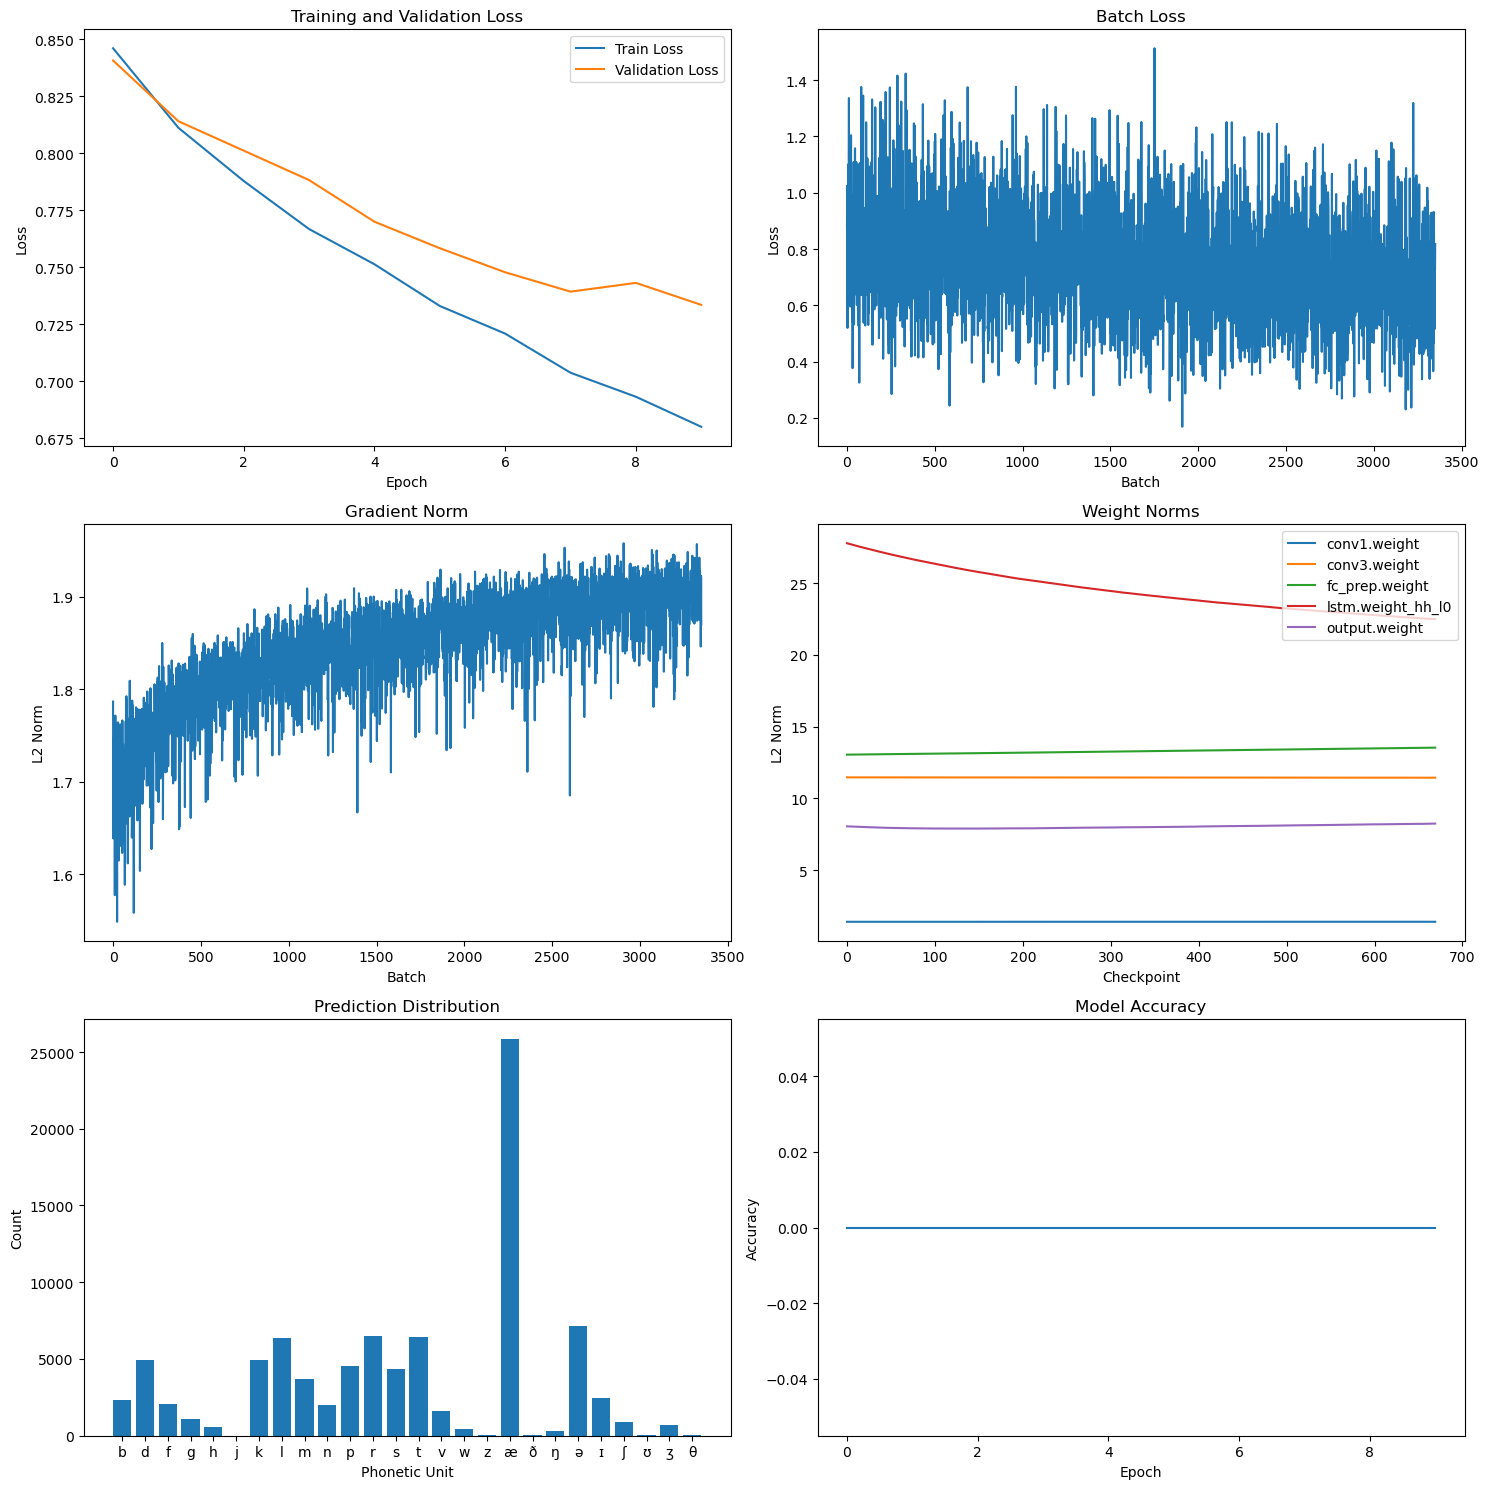

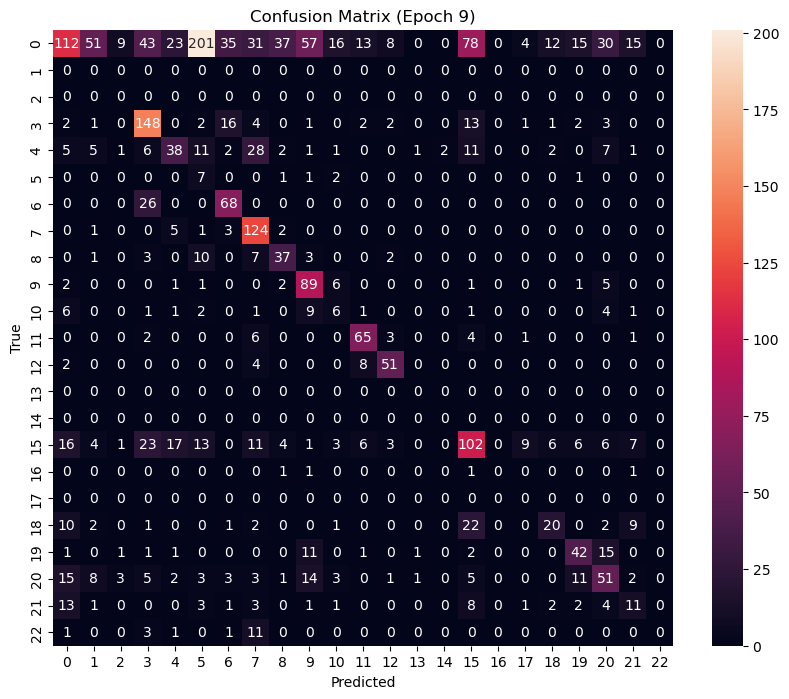

In [68]:
model = monitored_train(model, train_loader, val_loader)



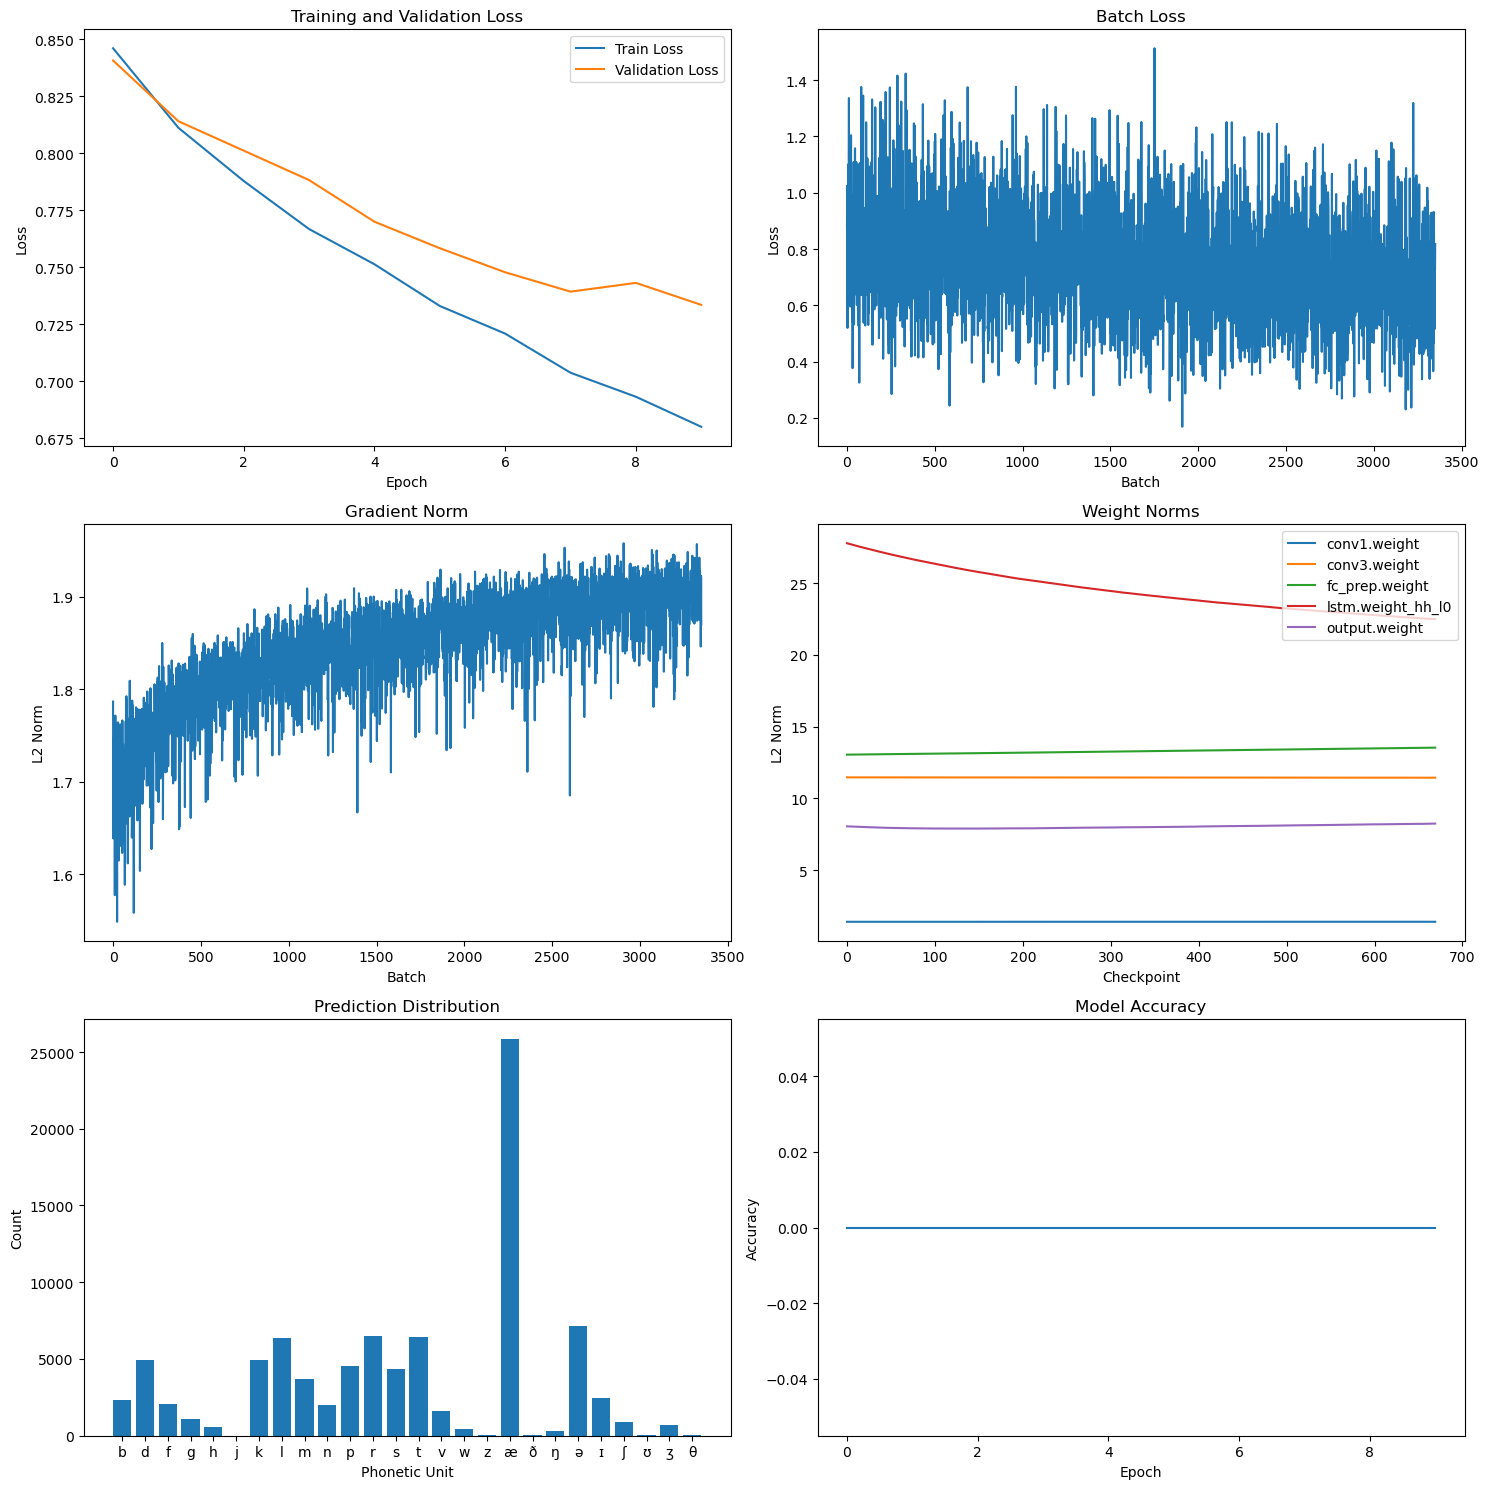

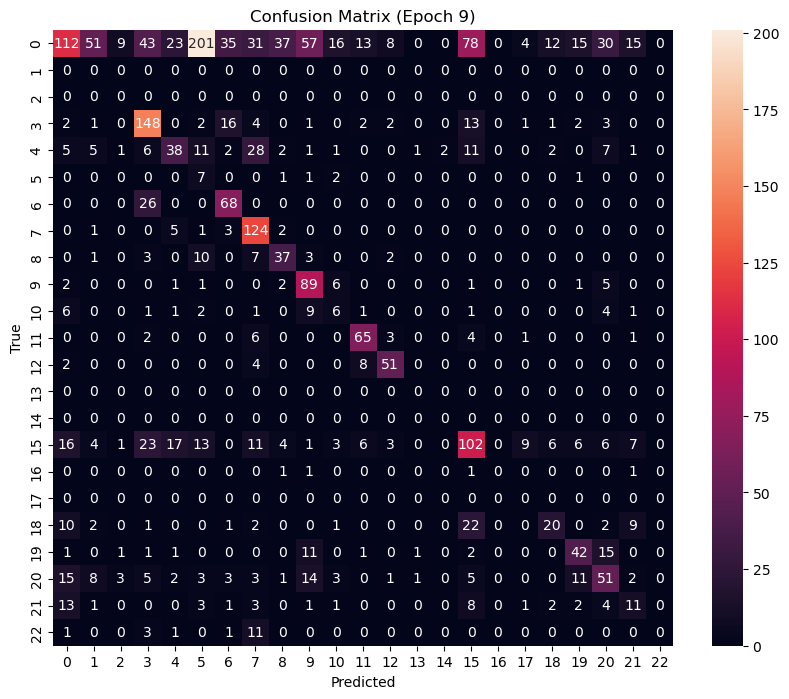

In [69]:
print(monitor.get_diagnostic_report())
monitor.plot_metrics()
